# Demo of Predictive State Smoothing (PRESS)

PRESS is a kernel smoothing technique for any type of predictive learning problem (classification, regression, ...).

This notebook shows examples of how to use the main functionality for a regression and classification problem.  Core PRESS functionality and layers, though, can be used for any learning problem with non-standard activation functions.

See also


* Goerg (2018) *[Classification using Predictive State Smoothing (PRESS): A scalable kernel classifier for high-dimensional features with variable selection](https://research.google/pubs/pub46767/)*.

* Goerg (2017) *[Predictive State Smoothing (PRESS): Scalable non-parametric regression for high-dimensional data with variable selection](https://research.google/pubs/pub46141/).*


In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib
import tensorflow as tf

from os.path import dirname
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import logging
import datetime
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [3]:
from pypress import layers
from pypress import initializers
from pypress import regularizers
from pypress import utils

importlib.reload(layers)

<module 'pypress.layers' from '/home/georg/Projects/pypress/pypress/layers.py'>

# Utility functions and setup

In [4]:
# misc helper functions
from typing import Tuple, Any
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import RobustScaler


def _get_loss_activation_metrics(y: pd.Series) -> Tuple[Any, Any, Any]:

    if len(np.unique(y)) == 2:
        act = "sigmoid"
        loss_fn = "binary_crossentropy"
        metrics = [tf.keras.metrics.AUC(curve="PR", name="aupr"), tf.keras.metrics.AUC(curve="ROC", name="auc_roc")]
    else:
        act = "linear"
        loss_fn = "mse"
        metrics = [tf.keras.metrics.mean_squared_error]
        
        if (y >= 0.).all():
            act = "softplus"
            loss_fn = "mse"

    return (loss_fn, act, metrics)


def _get_recommended_callbacks():
    logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logdir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
    return [tf.keras.callbacks.EarlyStopping(patience=10),
                             tensorboard_callback], logdir


def _scale_df(X, scaler = None):
    
    if scaler is None:
        scaler = RobustScaler()
        scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index), scaler


def _train_test_scale(X, y):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    X_train_s, scaler = _scale_df(X_train, None)
    X_test_s, scaler = _scale_df(X_test, scaler)
    
    return (X_train, y_train, X_test, y_test), scaler


# Regression


In [5]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)

In [6]:
X, y = housing["data"], housing["target"]
X.shape, y.shape

((20640, 8), (20640,))

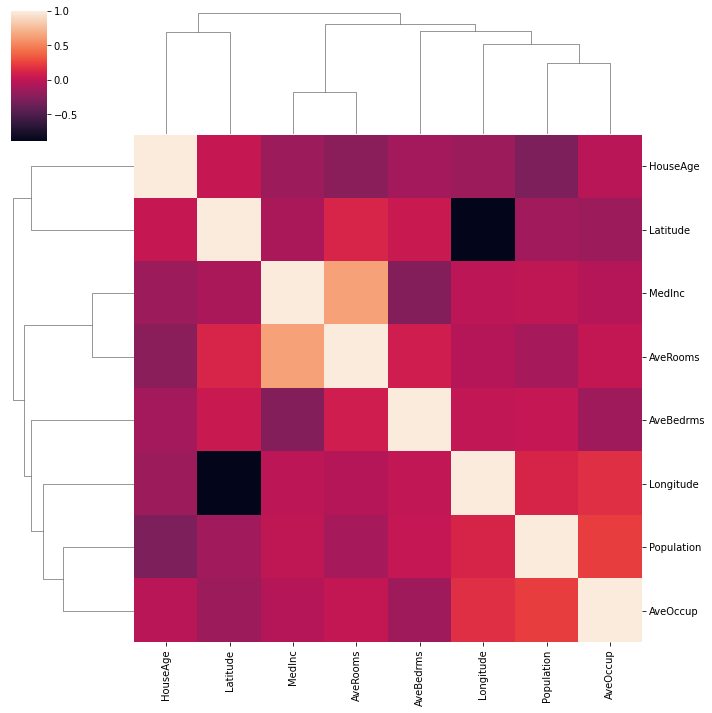

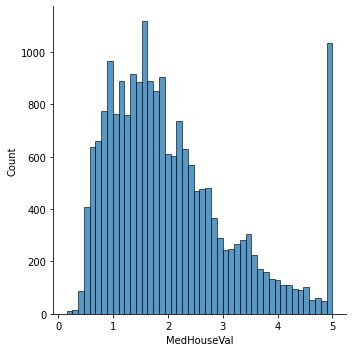

In [7]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [8]:
X = X.loc[y < 5]
y = y.loc[y < 5]

X.shape, y.shape

((19648, 8), (19648,))

In [ ]:
sns.clustermap(X.corr("spearman"))
plt.show()
sns.displot(y)

In [ ]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
importlib.reload(layers)
X_tr.shape

In [ ]:
loss_fn, act, metrics = _get_loss_activation_metrics(y_ts)
print(act)

feat_input = tf.keras.layers.Input(shape=(X_tr.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(50, "relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "selu", kernel_regularizer=tf.keras.regularizers.L2(0.00001)))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
#feat_eng_layer.add(tf.keras.layers.Dense(100, "tanh"))
#feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
#feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
pred_states = layers.PredictiveStatesSimplex(n_states=5, activity_regularizer=regularizers.DegreesOfFreedom(l1=0.1, df=2.0))(hidden)
state_mean_layer = layers.PredictiveStateMeans(units=1, activation=act)
pred = state_mean_layer(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005),
            metrics=metrics)
mod.summary()

In [ ]:
state_mean_layer.trainable_variables

In [ ]:
tf.keras.utils.plot_model(mod)

In [ ]:
history = mod.fit(X_tr, y_tr, epochs=20, batch_size=32,
                  validation_data=(X_ts, y_ts),
                  callbacks=[],#_get_recommended_callbacks()
                 )

In [ ]:
mod.layers[-1].state_conditional_means.numpy().ravel()

In [ ]:
sns.displot(y)

In [ ]:
y_pred = mod.predict(X)

sns.jointplot(y, y_pred.ravel(), kind="hex")

In [ ]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = state_mapping(X_ts.values).numpy()
pred_emb = pd.DataFrame(pred_emb, index=X_ts.index)
sns.heatmap(pred_emb)

In [ ]:
sns.pairplot(pred_emb)

In [ ]:
pred_emb.shape

In [ ]:
utils.col_normalize(pred_emb).sum(axis=0)

In [ ]:
X_ts.head()

In [ ]:
utils.size_state(pred_emb)

In [ ]:
utils.agg_data_by_state(pred_emb, X_ts).round(2)

# Classification

In [9]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

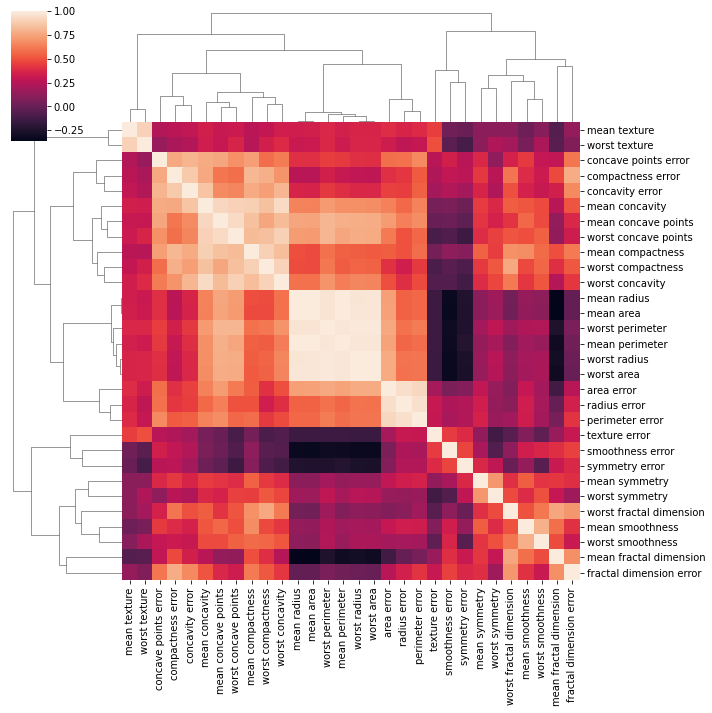

In [10]:
sns.clustermap(X.corr("spearman"))

In [11]:
y.value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

In [12]:
scaled_data, sc = _train_test_scale(X, y)
X_tr, y_tr, X_ts, y_ts = scaled_data
X_tr.shape, X_ts.shape

((455, 30), (114, 30))

In [13]:
loss_fn, act, metrics = _get_loss_activation_metrics(y)

feat_input = tf.keras.layers.Input(shape=(X.shape[1],))

feat_eng_layer = tf.keras.Sequential()
feat_eng_layer.add(tf.keras.layers.Dense(50, "selu"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())
feat_eng_layer.add(tf.keras.layers.Dense(30, "tanh"))
feat_eng_layer.add(tf.keras.layers.Dropout(0.25))
feat_eng_layer.add(tf.keras.layers.BatchNormalization())

hidden = feat_eng_layer(feat_input)
pred_states = layers.PredictiveStateSimplex(n_states=6, activity_regularizer=regularizers.NonUniform(0.6))(hidden)
pred = layers.PredictiveStateMeans(units=1, activation=act)(pred_states)

mod = tf.keras.Model(inputs=feat_input, outputs=pred)
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
            metrics=metrics)
mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 sequential (Sequential)     (None, 30)                3400      
                                                                 
 predictive_states_simplex (  (None, 6)                186       
 PredictiveStatesSimplex)                                        
                                                                 
 predictive_state_means (Pre  (None, 1)                6         
 dictiveStateMeans)                                              
                                                                 
Total params: 3,592
Trainable params: 3,432
Non-trainable params: 160
_________________________________________________________________


In [14]:
clbks, logdir_str = _get_recommended_callbacks()

logs/20211126-154305


In [15]:
history = mod.fit(X_tr, y_tr, epochs=50, 
                  validation_data=(X_ts, y_ts),
                  callbacks=clbks,
                 )

Epoch 1/50
15/15 [==============================] - 2s 28ms/step - loss: 0.6802 - aupr: 0.8846 - auc_roc: 0.8412 - val_loss: 0.6818 - val_aupr: 0.9626 - val_auc_roc: 0.9439
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 0.6449 - aupr: 0.9562 - auc_roc: 0.9336 - val_loss: 0.6765 - val_aupr: 0.9690 - val_auc_roc: 0.9554
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 0.6014 - aupr: 0.9466 - auc_roc: 0.9251 - val_loss: 0.6161 - val_aupr: 0.9803 - val_auc_roc: 0.9672
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 0.5557 - aupr: 0.9640 - auc_roc: 0.9490 - val_loss: 0.5399 - val_aupr: 0.9852 - val_auc_roc: 0.9733
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.5201 - aupr: 0.9763 - auc_roc: 0.9665 - val_loss: 0.4903 - val_aupr: 0.9861 - val_auc_roc: 0.9750
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 0.5070 - aupr: 0.9702 - auc_roc: 0.9564 - val_loss: 0.4789 - val_au

In [ ]:
%tensorboard --logdir logs/20211126-140158

In [16]:
preds = pd.DataFrame({"true": y_ts, "pred": mod.predict(X_ts).ravel()})

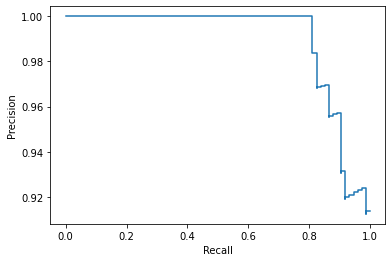

In [17]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(preds["true"], preds["pred"])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


(114, 30)


<AxesSubplot:>

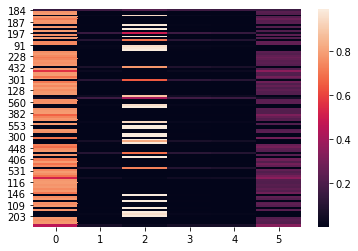

In [18]:
state_mapping = tf.keras.Model(inputs=feat_input, outputs=pred_states)
print(X_ts.shape)
pred_emb = pd.DataFrame(state_mapping(X_ts.values).numpy(), index=X_ts.index)
sns.heatmap(pred_emb)

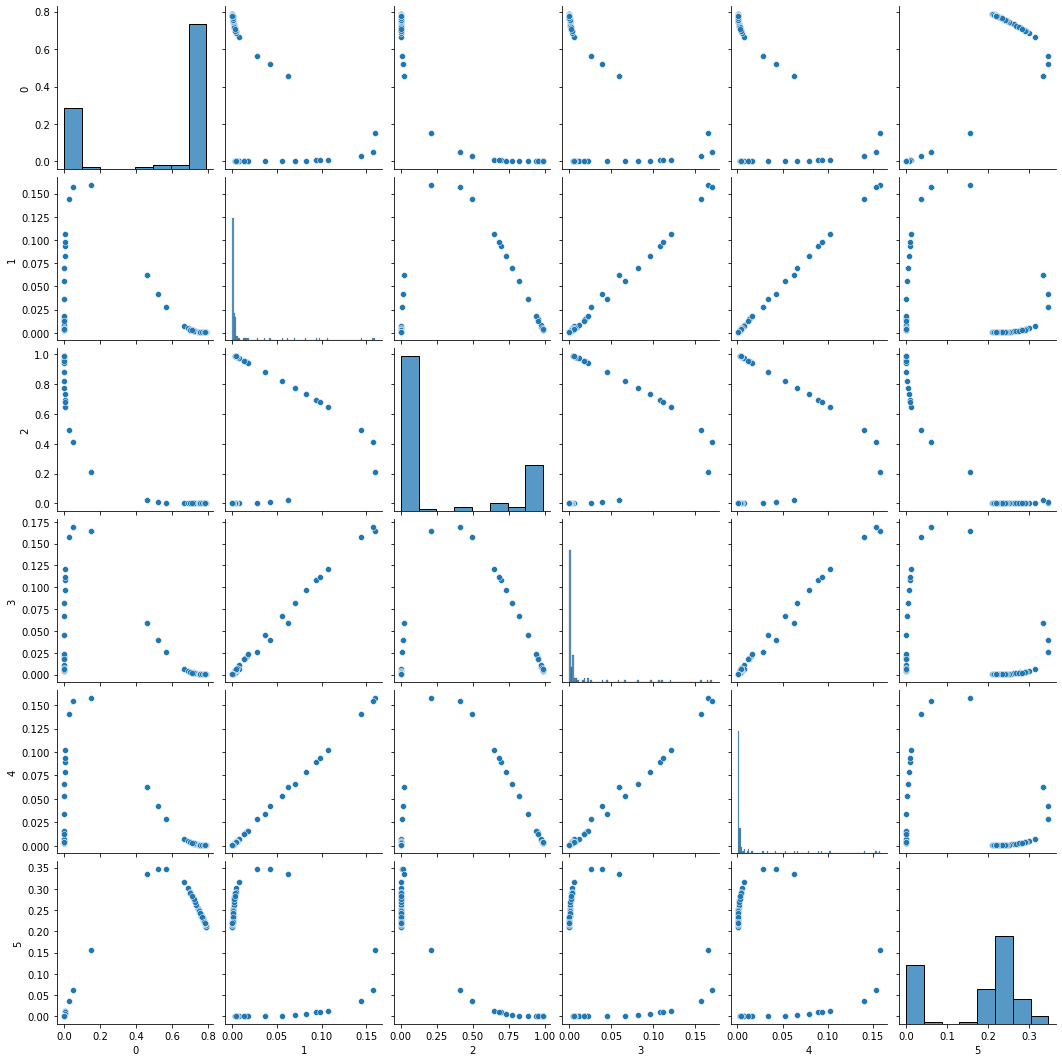

In [19]:
sns.pairplot(pred_emb)

In [20]:
X_state = utils.agg_data_by_state(X_ts, pred_emb)
X_state

,0,1,2,3,4,5
mean radius,12.444987,16.309183,18.447837,16.455352,16.258732,12.648652
mean texture,18.659896,21.186999,21.687771,21.271125,21.156802,18.842031
mean perimeter,80.350231,107.246336,121.823749,108.281225,106.888164,81.739519
mean area,483.222710,837.747274,1082.491475,852.971642,832.560850,499.566444
mean smoothness,0.093651,0.093982,0.101562,0.094351,0.093873,0.093751
mean compactness,0.089236,0.127929,0.146174,0.129793,0.127276,0.091014
mean concavity,0.055296,0.121730,0.164807,0.125526,0.120430,0.057479
mean concave points,0.030430,0.067490,0.094422,0.069539,0.066798,0.032110
mean symmetry,0.174913,0.184033,0.196262,0.184863,0.183761,0.175005
mean fractal dimension,0.063059,0.061702,0.061777,0.061720,0.061696,0.062928


In [21]:
mod.layers[-1].state_conditional_means.numpy()

array([[0.8353451 ],
       [0.398522  ],
       [0.21000335],
       [0.37200198],
       [0.40870392],
       [0.8078803 ]], dtype=float32)

In [22]:
utils.size_state(pred_emb)

state
0    61.068203
1     1.367255
2    28.915819
3     1.514519
4     1.325964
5    19.808231
dtype: float32

In [23]:
X_state

state,0,1,2,3,4,5
mean radius,12.444987,16.309183,18.447837,16.455352,16.258732,12.648652
mean texture,18.659896,21.186999,21.687771,21.271125,21.156802,18.842031
mean perimeter,80.350231,107.246336,121.823749,108.281225,106.888164,81.739519
mean area,483.222710,837.747274,1082.491475,852.971642,832.560850,499.566444
mean smoothness,0.093651,0.093982,0.101562,0.094351,0.093873,0.093751
mean compactness,0.089236,0.127929,0.146174,0.129793,0.127276,0.091014
mean concavity,0.055296,0.121730,0.164807,0.125526,0.120430,0.057479
mean concave points,0.030430,0.067490,0.094422,0.069539,0.066798,0.032110
mean symmetry,0.174913,0.184033,0.196262,0.184863,0.183761,0.175005
mean fractal dimension,0.063059,0.061702,0.061777,0.061720,0.061696,0.062928


<AxesSubplot:>

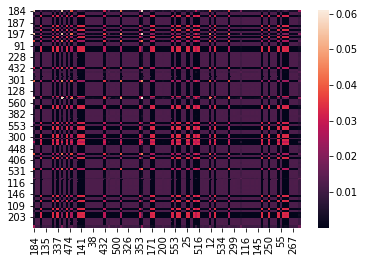

In [24]:
sns.heatmap(pred_emb.dot(utils.col_normalize(pred_emb).transpose()))

# Appendix

In [77]:
mod = tf.keras.Sequential()
mod.add(layers.PredictiveStateSimplex(n_states=6, activity_regularizer=regularizers.Uniform(0.01), input_dim=X.shape[1]))
mod.add(layers.PredictiveStateMeans(units=1, activation="sigmoid"))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictive_state_simplex_4   (None, 6)                186       
 (PredictiveStateSimplex)                                        
                                                                 
 predictive_state_means_7 (P  (None, 1)                6         
 redictiveStateMeans)                                            
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [78]:
mod.fit(X_tr, y_tr, epochs=2)

Epoch 1/2
15/15 [==============================] - 1s 1ms/step - loss: 0.7820 - aupr: 0.6193 - auc_roc: 0.4922
Epoch 2/2
15/15 [==============================] - 0s 1ms/step - loss: 0.7514 - aupr: 0.6391 - auc_roc: 0.5135


In [79]:
mod = tf.keras.Sequential()
mod.add(layers.PRESS(units=1, n_states=6, activation="sigmoid", activity_regularizer=regularizers.Uniform(0.01), input_dim=X.shape[1]))
mod.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
            metrics=metrics)
mod.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 press_13 (PRESS)            (None, 1)                 192       
                                                                 
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [80]:
mod.fit(X_tr, y_tr, epochs=12)

Epoch 1/12
15/15 [==============================] - 1s 1ms/step - loss: 0.7179 - aupr: 0.6149 - auc_roc: 0.5036
Epoch 2/12
15/15 [==============================] - 0s 1ms/step - loss: 0.6978 - aupr: 0.6075 - auc_roc: 0.4862
Epoch 3/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6851 - aupr: 0.6571 - auc_roc: 0.5503
Epoch 4/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6769 - aupr: 0.6227 - auc_roc: 0.4874
Epoch 5/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6707 - aupr: 0.6080 - auc_roc: 0.4986
Epoch 6/12
15/15 [==============================] - 0s 1ms/step - loss: 0.6676 - aupr: 0.6068 - auc_roc: 0.4870
Epoch 7/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6661 - aupr: 0.5926 - auc_roc: 0.4616
Epoch 8/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6648 - aupr: 0.5946 - auc_roc: 0.4615
Epoch 9/12
15/15 [==============================] - 0s 2ms/step - loss: 0.6643 - aupr: 0.5989 - auc_roc:

In [66]:
vr = layers.PRESS(units=1, n_states=6, activity_regularizer=regularizers.NonUniform(0.01), input_dim=X.shape[1],)

In [70]:
X.shape

(569, 30)

In [71]:
vr(tf.convert_to_tensor(X))

<tf.Tensor: shape=(569, 1), dtype=float32, numpy=
array([[-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
       [-0.09967256],
    